### Student Information
Name: Derrick Bol

Student ID: 108065434

GitHub ID: @derrxb

---

### Instructions

1. First: do the **take home** exercises in the [DM19-Lab1-Master Repo](https://github.com/EvaArevalo/DM19-Lab1-Master). You may need to copy some cells from the Lab notebook to this notebook. __This part is worth 20% of your grade.__


2. Second: follow the same process from the [DM19-Lab1-Master Repo](https://github.com/EvaArevalo/DM19-Lab1-Master) on **the new dataset**. You don't need to explain all details as we did (some **minimal comments** explaining your code are useful though).  __This part is worth 30% of your grade.__
    - Download the [the new dataset](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences#). The dataset contains a `sentence` and `score` label. Read the specificiations of the dataset for details. 
    - You are allowed to use and modify the `helper` functions in the folder of the first lab session (notice they may need modification) or create your own.


3. Third: please attempt the following tasks on **the new dataset**. __This part is worth 30% of your grade.__
    - Generate meaningful **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
    - Generate **TF-IDF features** from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency). Refer to this Sciki-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) .
    - Implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers. Comment on the differences.  Refer to this [article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/).


4. Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be habdled differently as well. What are those inefficent parts you noticed? How can you improve the Data preprocessing for these specific datasets? __This part is worth 10% of your grade.__


5. Fifth: It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**. __This part is worth 10% of your grade.__


You can submit your homework following these guidelines: [Git Intro & How to hand your homework](https://github.com/EvaArevalo/DM19-Lab1-Master/blob/master/Git%20Intro%20%26%20How%20to%20hand%20your%20homework.ipynb). Make sure to commit and save your changes to your repository __BEFORE the deadline (Oct. 29th 11:59 pm, Tuesday)__. 

## Part 1: Complete the take home exercises in the Lab Master file

This is completed and can be found on [Lab 1](DM19-Lab1-Master.ipynb)

## Part 2: Apply steps from Lab 1 on the new dataset

In [1]:
# necessary for when working with external scripts
%load_ext autoreload
%autoreload 2

import re
import math
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk as nltk
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
import plotly as py
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import helpers.data_mining_helpers as helpers
from nltk import ngrams
import plotly.express as px

%matplotlib inline

### Data Preparation & Transformation

Since the reviews are provided via three different files, we first need to combine them to have just one Pandas dataframe. However, I believe the source of the review might be important so we also want to keep track of their source.

In [2]:
# Using `\t` as the delimiter breaks each line into two columns. One for the review and the other for the score.
imdb = pd.read_csv('imdb_labelled.txt', delimiter="\t", names=["review", "score"])
yelp = pd.read_csv('yelp_labelled.txt', delimiter="\t", names=["review", "score"])
amzn = pd.read_csv('amazon_cells_labelled.txt', delimiter="\t", names=["review", "score"])

def append_with_source(original_df, df, source):
    df['source'] = source
    
    return original_df.append(df)

# Create one dataframe with three columns: review, score, and origin
# TODO: We can probably do this during the first import so that's something to look into.
reviews = imdb
reviews['source'] = 'imdb'
reviews = append_with_source(reviews, yelp, 'yelp')
reviews = append_with_source(reviews, amzn, 'amzn')

In [3]:
# What does a review actually look like? We take random small sample to print a few reviews.
print(reviews.sample(n=5))

                                                review  score source
825                          Won't ever go here again.      0   yelp
266             The service was not up to par, either.      0   yelp
339  It is practically useless and did not add any ...      0   amzn
674  Funny, clever, hip - just like Pray's previous...      1   imdb
663  I didn't realize how wonderful the short reall...      1   imdb


#### Missing values

Are there any missing values in the dataset provided? According to the results below, no missing values currently exist in the dataset.

In [4]:
reviews.isnull().apply(lambda x: helpers.check_missing_values(x))

review    The amoung of missing records is: 0
score     The amoung of missing records is: 0
source    The amoung of missing records is: 0
dtype: object

In [5]:
# We then check the missing values by record rather than by column.
# The answer is still that no missing values exist
reviews.isnull().apply(lambda x: helpers.check_missing_values(x), axis = 1)

0      The amoung of missing records is: 0
1      The amoung of missing records is: 0
2      The amoung of missing records is: 0
3      The amoung of missing records is: 0
4      The amoung of missing records is: 0
                      ...                 
995    The amoung of missing records is: 0
996    The amoung of missing records is: 0
997    The amoung of missing records is: 0
998    The amoung of missing records is: 0
999    The amoung of missing records is: 0
Length: 2748, dtype: object

#### Duplicate data

We would like to know if there are any duplicate data in our dataset.

In [6]:
sum(reviews.duplicated())

17

In [7]:
reviews[reviews.duplicated()]

review  score source
165                   Definitely worth checking out.        1   imdb
387                                 Not recommended.        0   imdb
590                                            10/10        1   imdb
814                                 I love this place.      1   yelp
816                             The food was terrible.      0   yelp
843                                   I won't be back.      0   yelp
846                  I would not recommend this place.      0   yelp
285                                      Great phone!.      1   amzn
407                                       Works great.      1   amzn
524                                      Works great!.      1   amzn
543                            Don't buy this product.      0   amzn
744  If you like a loud buzzing to override all you...      0   amzn
748                                      Does not fit.      0   amzn
778                              This is a great deal.      1   amzn
792                                       Great Phone.      1   amzn
892                   Excellent product for the price.      1   amzn
896                                       Great phone.      1   amzn

From the results above, we can see that duplicates do exist. However, I am not sure if we should remove the duplicate reviews. For example, one review that keeps showing up is the `Great Phone` review. Does it make sense to remove this review? This could mean that multiple people bought the phone and they both liked it.

I decided to remove the duplicates since it's a very tiny portion of the dataset.

In [8]:
reviews.drop_duplicates(keep=False, inplace=True)
sum(reviews.duplicated())

0

### Data Preprocessing

The various preprocessing techniques were performed on the reviews dataset.

- Aggregation
- Sampling
- Dimensionality Reduction
- Feature Subset Selection
- Feature Creation
- Discretization and Binarization
- Attribute Transformation

### Feature Creation

We create tokens from the review

In [9]:
reviews['unigrams'] = reviews['review'].apply(lambda x: helpers.tokenize_text(x))

### Feature Subselection

We create a document term matrix from the sample of the dataset. However, before this is done, we first clean the dataset by removing stop words. Removing stop words is one thing the Lab 1 did not do so this helps to reduce the size of the DTM. We don't remove numbers because those might be useful in a review. i.e If a review gives a product or movie a `10/10` score.

In [10]:
# Data cleaning method uses regex to find and replace text.
def clean_data(text):
    text = text.lower()
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('_+[^a-z]', '', text)
    text = re.sub('_+[a-z]', '', text)
    text = re.sub('[''""...]', '', text)
    text = text.replace(",", "")
    
    return text

# Uses the common stop words provided by `nltk`
stop = stopwords.words('english')

def remove_stopwords(text):
    # Sets up regex to filter out stop words    
    pattern = re.compile(r'\b(' + r'|'.join(stop) + r')\b\s*')

    return pattern.sub('', text)

In [11]:
# Apply data cleaning
reviews['cleaned_review'] = reviews['review'].apply(lambda x: remove_stopwords(clean_data(x)))

In [12]:
reviews.iloc[0:10]

review  score source  \
0  A very, very, very slow-moving, aimless movie ...      0   imdb   
1  Not sure who was more lost - the flat characte...      0   imdb   
2  Attempting artiness with black & white and cle...      0   imdb   
3       Very little music or anything to speak of.        0   imdb   
4  The best scene in the movie was when Gerardo i...      1   imdb   
5  The rest of the movie lacks art, charm, meanin...      0   imdb   
6                                Wasted two hours.        0   imdb   
7  Saw the movie today and thought it was a good ...      1   imdb   
8                               A bit predictable.        0   imdb   
9  Loved the casting of Jimmy Buffet as the scien...      1   imdb   

                                            unigrams  \
0  [A, very, ,, very, ,, very, slow-moving, ,, ai...   
1  [Not, sure, who, was, more, lost, -, the, flat...   
2  [Attempting, artiness, with, black, &, white, ...   
3  [Very, little, music, or, anything, to, speak,...   
4  [The, best, scene, in, the, movie, was, when, ...   
5  [The, rest, of, the, movie, lacks, art, ,, cha...   
6                            [Wasted, two, hours, .]   
7  [Saw, the, movie, today, and, thought, it, was...   
8                           [A, bit, predictable, .]   
9  [Loved, the, casting, of, Jimmy, Buffet, as, t...   

                                      cleaned_review  
0  slow-moving aimless movie distressed drifting ...  
1  sure lost - flat characters audience nearly ha...  
2  attempting artiness black & white clever camer...  
3                       little music anything speak   
4  best scene movie gerardo trying find song keep...  
5  rest movie lacks art charm meaning 'emptiness ...  
6                                 wasted two hours    
7  saw movie today thought good effort good messa...  
8                                  bit predictable    
9       loved casting jimmy buffet science teacher

In [13]:
# Create Document Term Matrix
reviews_count_vect = CountVectorizer()
reviews_count = reviews_count_vect.fit_transform(reviews.cleaned_review)

print(f"Number of feature names: {len(reviews_count_vect.get_feature_names())}")

Number of feature names: 4987


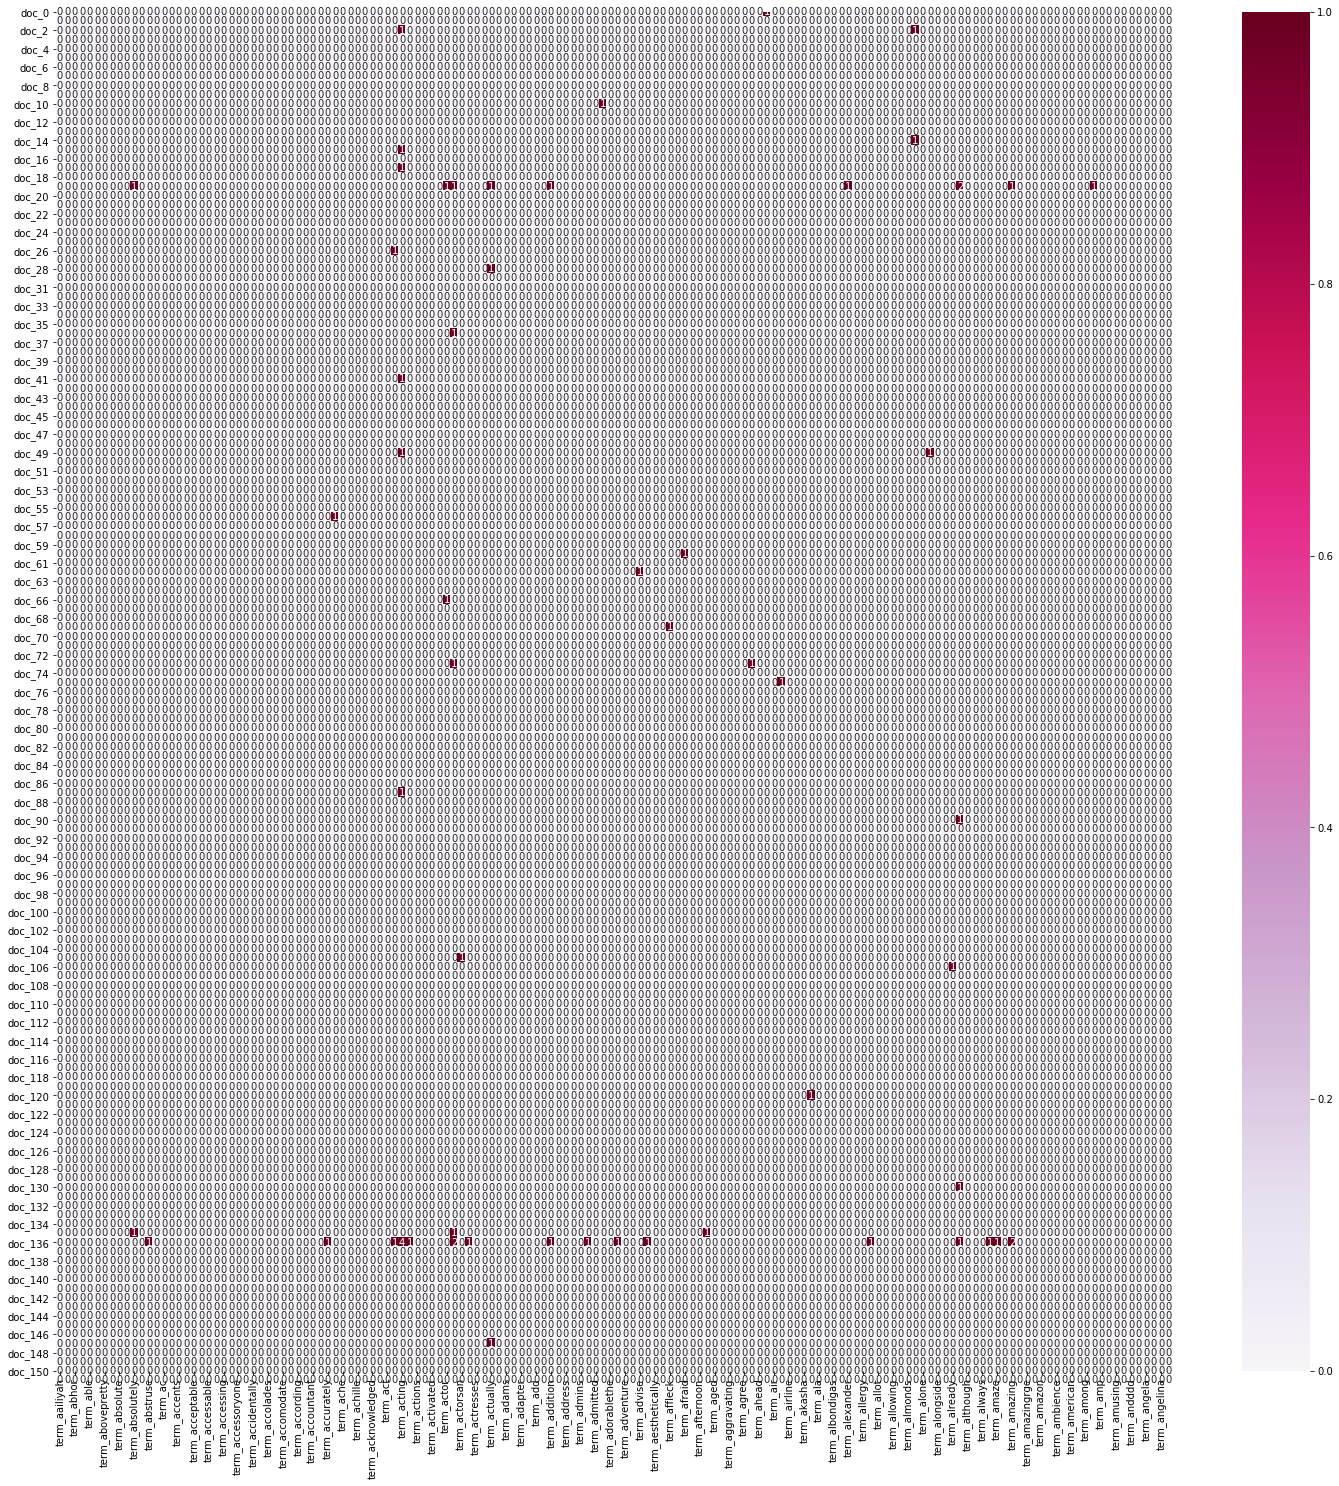

In [14]:
# Even though we have a sparse matrix, we graph it to get an idea of what it looks like.
# Graphing Stuff
plot_x = ["term_"+str(i) for i in reviews_count_vect.get_feature_names()[0:150]]
plot_y = ["doc_"+ str(i) for i in list(reviews.index[0:150])] 
plot_z = reviews_count[0:150, 0:150].toarray()

df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(25, 25))
ax = sns.heatmap(df_todraw, cmap="PuRd", vmin=0, vmax=1, annot=True)

#### Sampling

Even though our dataset is pretty small, we still obtain a sample to work with. This will be useful to allow my computer's processing power to handle the graphing and other performance intensive tasks.

In [15]:
reviews_sample = reviews.sample(n=1500)

reviews_sample[0:10]

review  score source  \
287  This movie was kind of long in length, but I e...      1   imdb   
7    Saw the movie today and thought it was a good ...      1   imdb   
487  I dont think I will be back for a very long time.      0   yelp   
954  The fries were not hot, and neither was my bur...      0   yelp   
512  The sound is clear and the people I talk to on...      1   amzn   
473                        Don't waste your time here.      0   yelp   
781  I bought these hoping I could make my Bluetoot...      0   amzn   
551  I guess I liked the details of his dysfunction...      1   imdb   
697                                Simply beautiful.        1   imdb   
258  This film (and I use that word loosely) is an ...      0   imdb   

                                              unigrams  \
287  [This, movie, was, kind, of, long, in, length,...   
7    [Saw, the, movie, today, and, thought, it, was...   
487  [I, dont, think, I, will, be, back, for, a, ve...   
954  [The, fries, were, not, hot, ,, and, neither, ...   
512  [The, sound, is, clear, and, the, people, I, t...   
473              [Do, n't, waste, your, time, here, .]   
781  [I, bought, these, hoping, I, could, make, my,...   
551  [I, guess, I, liked, the, details, of, his, dy...   
697                             [Simply, beautiful, .]   
258  [This, film, (, and, I, use, that, word, loose...   

                                        cleaned_review  
287       movie kind long length enjoyed every minute   
7    saw movie today thought good effort good messa...  
487                          dont think back long time  
954                           fries hot neither burger  
512            sound clear people talk amazed quality   
473                                       'waste time   
781  bought hoping could make bluetooth headset fit...  
551      guess liked details dysfunction--believable    
697                                 simply beautiful    
258  film (use word loosely) insult movie-going pub...

With the sample data and the original data, we do a side-by-side comparison of the distribution of the `score` and review `origin` between the two datasets.

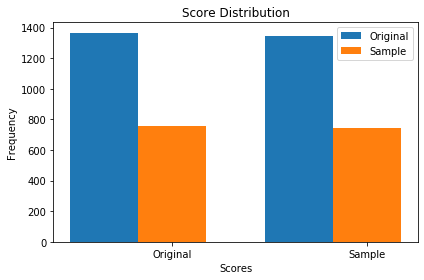

In [16]:
original_score_count = reviews.score.value_counts()
sample_score_count = reviews_sample.score.value_counts()
score_categories = ['Original', 'Sample']

x_axis = np.arange(len(score_categories))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x_axis - width/2, original_score_count, width, label=score_categories[0])
rects2 = ax.bar(x_axis + width/2, sample_score_count, width, label=score_categories[1])

plt.xticks(x_axis + width / 2, score_categories)
plt.ylabel('Frequency')
plt.xlabel('Scores')

plt.legend(loc='best')
plt.title('Score Distribution')

fig.tight_layout()
plt.show()

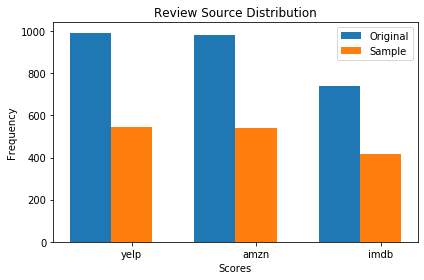

In [17]:
original_source_count = reviews.source.value_counts()
sample_source_count = reviews_sample.source.value_counts()
source_categories = ['yelp', 'amzn', 'imdb']

x_axis = np.arange(len(source_categories))
width = 0.33

fig, ax = plt.subplots()
rects1 = ax.bar(x_axis - width/2, original_source_count, width, label="Original")
rects1 = ax.bar(x_axis + width/2, sample_source_count, width, label="Sample")

plt.xticks(x_axis + width / 2, source_categories)
plt.ylabel('Frequency')
plt.xlabel('Scores')

plt.legend(loc='best')
plt.title('Review Source Distribution')

fig.tight_layout()
plt.show()

As you can see from the graphs above, the sample scores and the sample reviews source are a good representation of the original dataset.

### Dimensionality Reduction

Similar to in the lab, we use Principal Component Analysis to reduce the dimensions of the reviews data. We do this to visualize variation in the data.

In [18]:
reviews_reduced = PCA(n_components = 3).fit_transform(reviews_count.toarray())

print(reviews_reduced)

[[ 0.31572601 -0.08251228  0.0812292 ]
 [-0.05572123 -0.05281172 -0.09012424]
 [ 0.61421357 -0.18461515  0.07937208]
 ...
 [-0.17978954  0.00931313 -0.02668884]
 [-0.13900218 -0.05575096  0.04999394]
 [-0.14784323 -0.06760492  0.01097185]]


In [19]:
reviews_reduced.shape

(2714, 3)

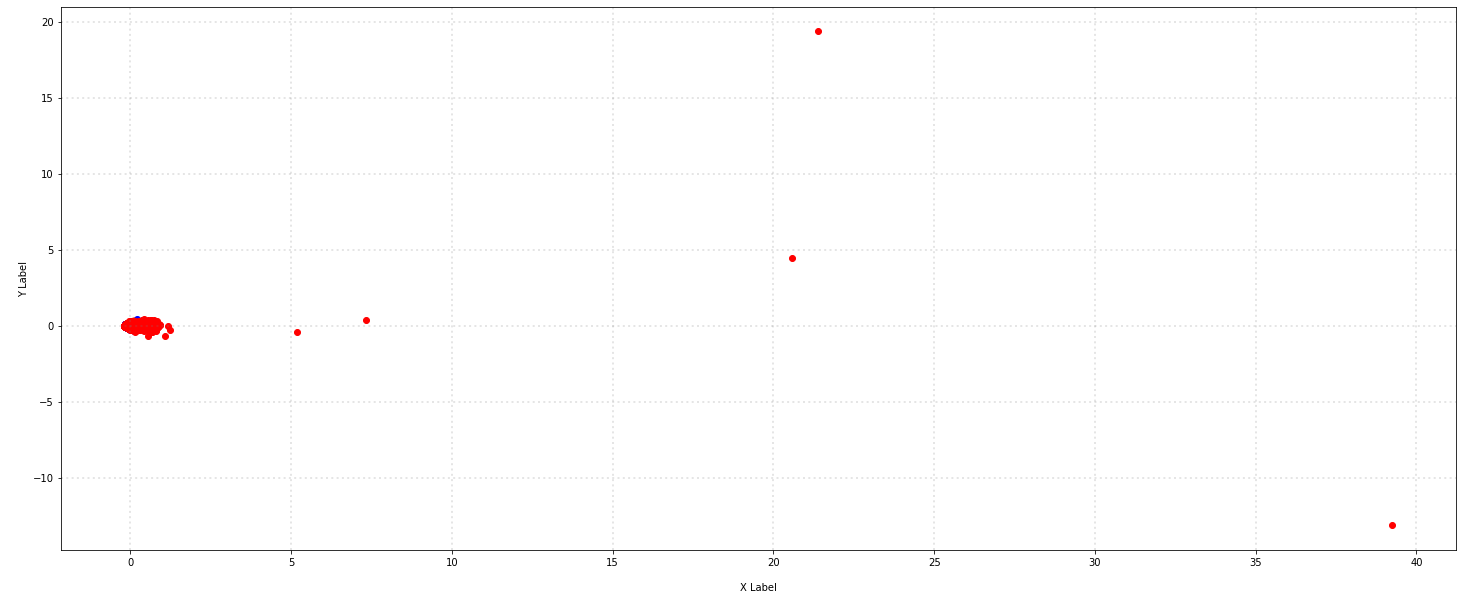

In [20]:
col = ['coral', 'blue', 'red', 'orange']
categories = ['amzn', 'yelp', 'imdb']

# plot
fig = plt.figure(figsize = (25,10))
ax = fig.subplots()

for c, category in zip(col, categories):
    xs = reviews_reduced[reviews['source'] == category].T[0]
    ys = reviews_reduced[reviews['source'] == category].T[1]
   
    ax.scatter(xs, ys, c = c, marker='o')

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')

plt.show()

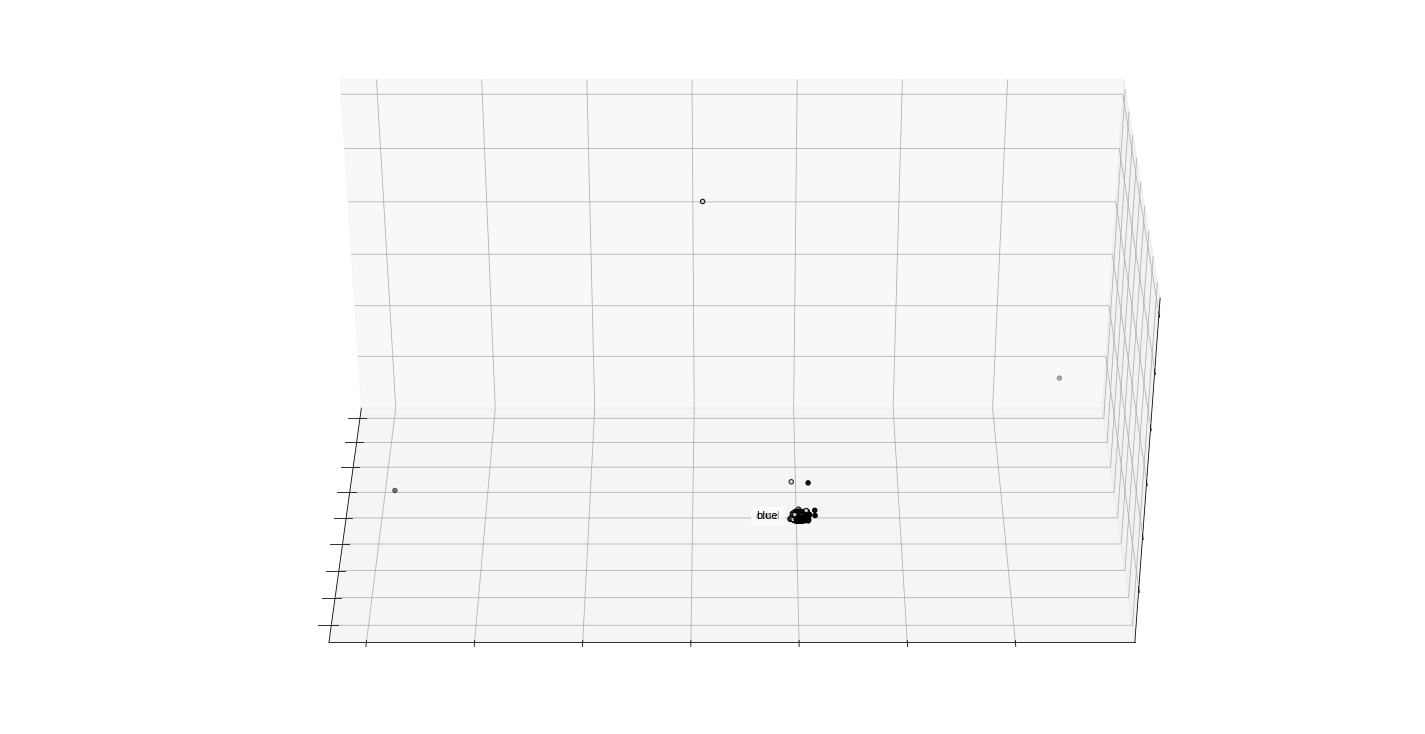

In [21]:
X3d_reduced = PCA(n_components = 3).fit_transform(reviews_count.toarray())
y = reviews["score"].values
categories = [0, 1]
fig = plt.figure(1, figsize = (20,10))
plt.clf()

ax = Axes3D(fig, rect=[0, 0, .98, 1], elev=34, azim=180)

for color, category in zip(col, categories):
    ax.text3D(X3d_reduced[reviews['score'] == category, 0].mean(),
              X3d_reduced[reviews['score'] == category, 1].mean() + 1.5,
              X3d_reduced[reviews['score'] == category, 2].mean(), color,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0, 3]).astype(np.float)

ax.scatter(X3d_reduced[:, 0], X3d_reduced[:, 1], X3d_reduced[:, 2], c=y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

### 5.5 Atrribute Transformation / Aggregation

Calculate the term frequencies for each review to generate a simple distribution of words found in all reviews. However, since doing the calculation on the whole dataset is memory intensive, we will get the term frequencies for the `reviews_sample`

In [22]:
sample_count_vect = CountVectorizer()
sample_count = sample_count_vect.fit_transform(reviews_sample.cleaned_review)

term_frequencies = []

for j in range(0, sample_count.shape[1]):
    term_frequencies.append(sum(sample_count[:,j].toarray()))
    
term_frequencies = np.asarray(sample_count.sum(axis=0))[0]

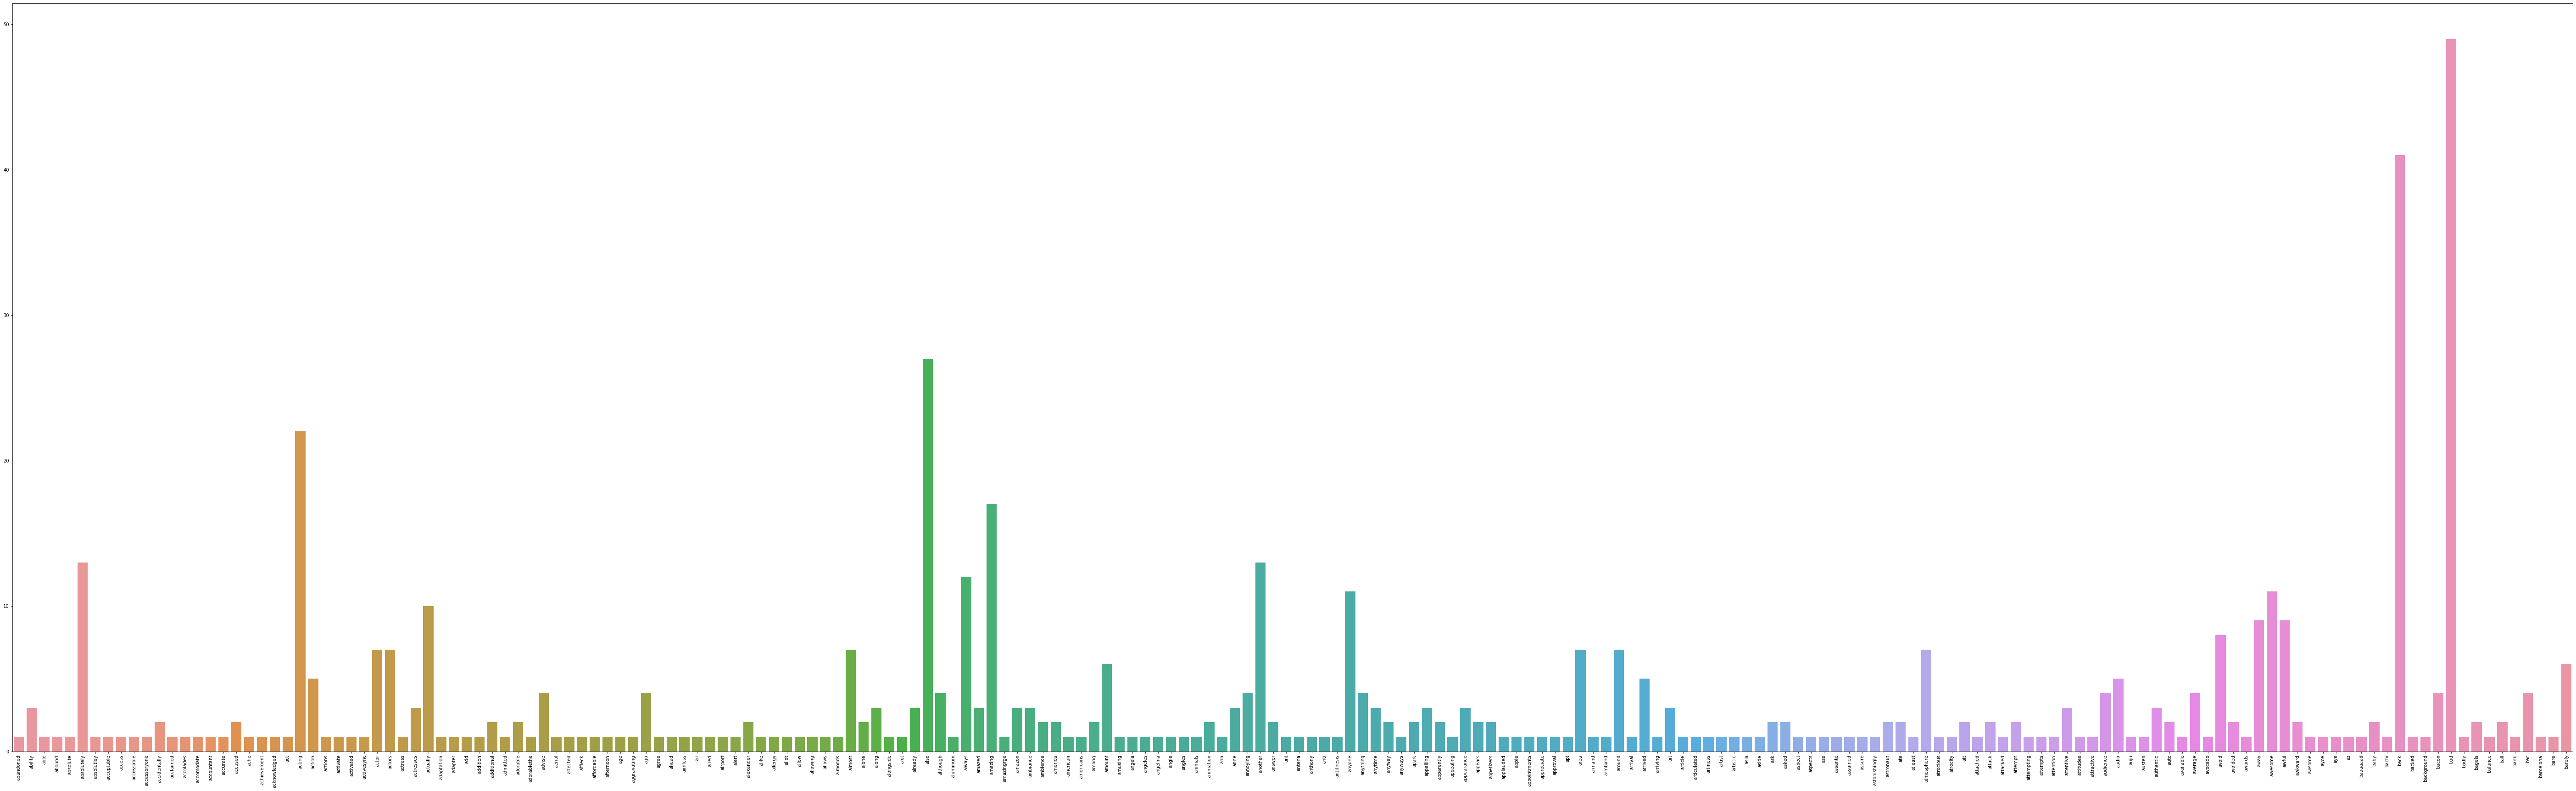

In [23]:
# We graph the term frequencies
plt.subplots(figsize=(100, 30))

g = sns.barplot(x=sample_count_vect.get_feature_names()[:200], y=term_frequencies[:200])
g.set_xticklabels(sample_count_vect.get_feature_names()[:200], rotation = 90);

We use `Plotly` to generate a more interactive graph

In [24]:
# Set up styling and graphing details for the plotly graph
trace = {
    "type": "bar",
    "y": term_frequencies[:100],
    "x": sample_count_vect.get_feature_names()[:100],
    "marker": {"color": "rgb(222, 113, 88)"},
    "orientation": 'v'
}

layout = {
    "title": "Word Frequency",
    "width": 1000,
    "yaxis": {
        "title": "Frequency",
        "gridcolor": "white"
    },
    "xaxis": {
        "title": "Words",
        "zeroline": False,
        "gridcolor": "white"
    },
    "height": 720,
    "barmode": "group",
    "autosize": True,
    "showlegend": False,
    "orientation": 90,
    "plot_bgcolor": "rgba(0,0,0,0)",
    "paper_bgcolor": "rgba(0,0,0,0)"
}

# Display the graph
fig = go.Figure()
fig.add_trace(trace)
# fig.update_layout(layout)
fig.show()

We can also sort the term counts in descending order to see what the most popular terms are.

In [25]:
# We sort the word frequency in descending order
sorted_freqs = sorted(zip(term_frequencies[:500], sample_count_vect.get_feature_names()[:500]), reverse=True)
yaxis = [x[0] for x in sorted_freqs]
xaxis = [x[1] for x in sorted_freqs]

trace = {
    "type": "bar",
    "y": yaxis,
    "x": xaxis,
    "marker": {"color": "rgb(222, 113, 88)"},
    "orientation": 'v',
}

# Display the graph
fig = go.Figure()
fig.add_trace(trace)
# We can use the same layout defined in the cell above.
fig.update_layout(layout)
fig.show()


In [26]:
# We sort the word frequency in descending order for a subset of the terms. We then calculate the log on
# the frequencies.
sorted_by_freq = sorted(zip(term_frequencies[:200], sample_count_vect.get_feature_names()[:200]), reverse=True)

term_freq = [x[0] for x in sorted_by_freq]
terms = [x[1] for x in sorted_by_freq]

# We add 1 to the frequency to avoid having 0 values. Not sure if this is the recommended approach here.
# Any feedback would be appreciated :)
term_frequencies_log = [math.log(i + 1) for i in term_freq]

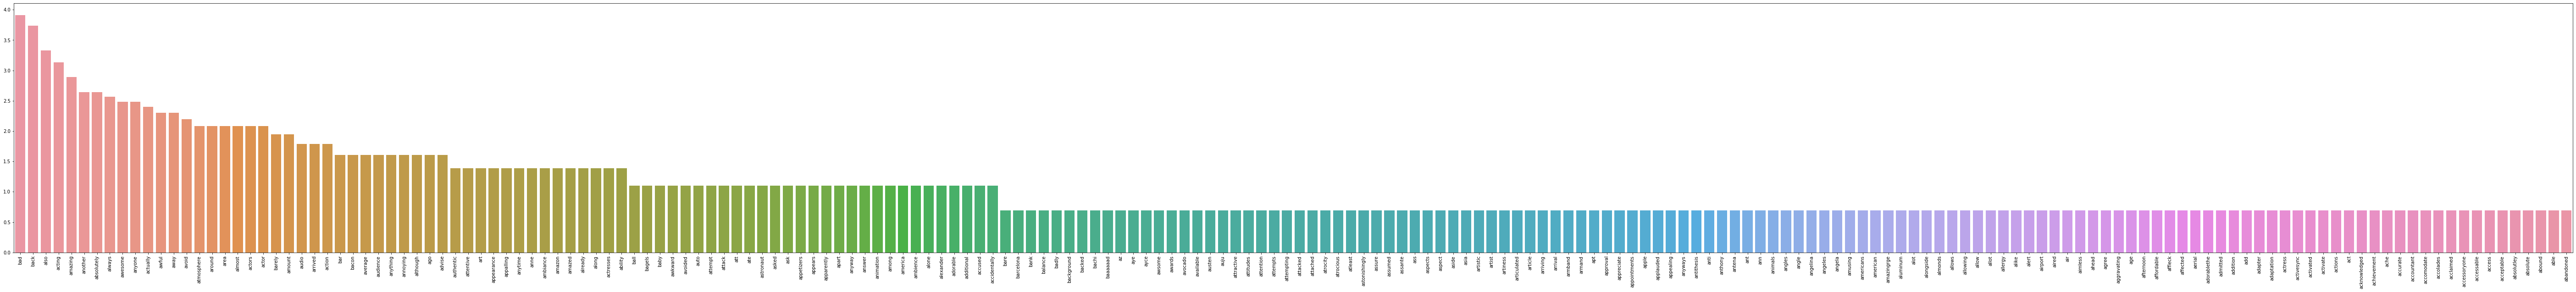

In [27]:
plt.subplots(figsize=(100, 10))

g = sns.barplot(x=terms, y=term_frequencies_log)
g.set_xticklabels(terms, rotation = 90);

### 5.6 Discretization and Binarization

We peform one-hot encoding on the `source` of the reviews.

In [28]:
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy

In [29]:
mlb = preprocessing.LabelBinarizer()
mlb.fit(reviews.source)
mlb.classes_
reviews['bin_source'] = mlb.transform(reviews['source']).tolist()

In [30]:
reviews[0:9]

review  score source  \
0  A very, very, very slow-moving, aimless movie ...      0   imdb   
1  Not sure who was more lost - the flat characte...      0   imdb   
2  Attempting artiness with black & white and cle...      0   imdb   
3       Very little music or anything to speak of.        0   imdb   
4  The best scene in the movie was when Gerardo i...      1   imdb   
5  The rest of the movie lacks art, charm, meanin...      0   imdb   
6                                Wasted two hours.        0   imdb   
7  Saw the movie today and thought it was a good ...      1   imdb   
8                               A bit predictable.        0   imdb   

                                            unigrams  \
0  [A, very, ,, very, ,, very, slow-moving, ,, ai...   
1  [Not, sure, who, was, more, lost, -, the, flat...   
2  [Attempting, artiness, with, black, &, white, ...   
3  [Very, little, music, or, anything, to, speak,...   
4  [The, best, scene, in, the, movie, was, when, ...   
5  [The, rest, of, the, movie, lacks, art, ,, cha...   
6                            [Wasted, two, hours, .]   
7  [Saw, the, movie, today, and, thought, it, was...   
8                           [A, bit, predictable, .]   

                                      cleaned_review bin_source  
0  slow-moving aimless movie distressed drifting ...  [0, 1, 0]  
1  sure lost - flat characters audience nearly ha...  [0, 1, 0]  
2  attempting artiness black & white clever camer...  [0, 1, 0]  
3                       little music anything speak   [0, 1, 0]  
4  best scene movie gerardo trying find song keep...  [0, 1, 0]  
5  rest movie lacks art charm meaning 'emptiness ...  [0, 1, 0]  
6                                 wasted two hours    [0, 1, 0]  
7  saw movie today thought good effort good messa...  [0, 1, 0]  
8                                  bit predictable    [0, 1, 0]

### Data Exploration

I think it would be interesting to see what the various reviews look like. So in this section we'll get 1 random review each from each of the sources.

In [31]:
review_to_transform_1 = []
rand_review_1 = reviews[reviews['source'] == 'imdb'].iloc[50]
rand_review_1 = rand_review_1['review']
review_to_transform_1.append(rand_review_1)

review_to_transform_2 = []
rand_review_2 = reviews[reviews['source'] == 'amzn'].iloc[25]
rand_review_2 = rand_review_2['review']
review_to_transform_2.append(rand_review_2)

review_to_transform_3 = []
rand_review_3 = reviews[reviews['source'] == 'yelp'].iloc[25]
rand_review_3 = rand_review_3['review']
review_to_transform_3.append(rand_review_3)

In [32]:
print(review_to_transform_1)
print(review_to_transform_2)
print(review_to_transform_3)

['The movie was so boring, that I sometimes found myself occupied peaking in the paper instead of watching (never happened during a Columbo movie before!  ']
["I've owned this phone for 7 months now and can say that it's the best mobile phone I've had."]
["That's right....the red velvet cake.....ohhh this stuff is so good."]


In [33]:
from sklearn.preprocessing import binarize

# Transform sentence with Vectorizers
review_vector_count_1 = reviews_count_vect.transform(review_to_transform_1)
review_vector_count_2 = reviews_count_vect.transform(review_to_transform_2)
review_vector_count_3 = reviews_count_vect.transform(review_to_transform_3)

# Binarize vecors to simplify: 0 for abscence, 1 for prescence
review_vector_count_1_bin = binarize(review_vector_count_1)
review_vector_count_2_bin = binarize(review_vector_count_2)
review_vector_count_3_bin = binarize(review_vector_count_3)

# print
print("Let's take a look at the count vectors:")
print(review_vector_count_1.todense())
print(review_vector_count_2.todense())
print(review_vector_count_3.todense())

Let's take a look at the count vectors:
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]


In [34]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate Cosine Similarity
cos_sim_count_1_2 = cosine_similarity(review_vector_count_1, review_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(review_vector_count_1, review_vector_count_3, dense_output=True)
cos_sim_count_1_1 = cosine_similarity(review_vector_count_1, review_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(review_vector_count_2, review_vector_count_2, dense_output=True)

# Print 
print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})

Cosine Similarity using count bw 1 and 2: 0.000000
Cosine Similarity using count bw 1 and 3: 0.000000
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000


As mentioned in the lab details, the cosine similarity between a sentence and itself is 1 while the similarity between two completely different sentence is 0. From the results we see above, the similarity between reviews from different sources is 0. That means they have nothing in common.

We now calculate the similarity between documents from the same sources.

In [35]:
review_to_transform_4 = []
rand_review_4 = reviews[reviews['source'] == 'imdb'].iloc[50]
rand_review_4 = rand_review_4['review']
review_to_transform_4.append(rand_review_4)

review_to_transform_5 = []
rand_review_5 = reviews[reviews['source'] == 'imdb'].iloc[34]
rand_review_5 = rand_review_5['review']
review_to_transform_5.append(rand_review_5)

review_to_transform_6 = []
rand_review_6 = reviews[reviews['source'] == 'imdb'].iloc[60]
rand_review_6 = rand_review_6['review']
review_to_transform_6.append(rand_review_6)

print(review_to_transform_4)
print(review_to_transform_5)
print(review_to_transform_6)

# Transform sentence with Vectorizers
review_vector_count_4 = reviews_count_vect.transform(review_to_transform_4)
review_vector_count_5 = reviews_count_vect.transform(review_to_transform_5)
review_vector_count_6 = reviews_count_vect.transform(review_to_transform_6)

# Binarize vecors to simplify: 0 for abscence, 1 for prescence
review_vector_count_4_bin = binarize(review_vector_count_4)
review_vector_count_5_bin = binarize(review_vector_count_5)
review_vector_count_6_bin = binarize(review_vector_count_6)

['The movie was so boring, that I sometimes found myself occupied peaking in the paper instead of watching (never happened during a Columbo movie before!  ']
['The scenes are often funny and occasionally touching as the characters evaluate their lives and where they are going.  ']
['The music in the film is really nice too.  ']


In [36]:
# Calculate Cosine Similarity
cos_sim_count_4_5 = cosine_similarity(review_vector_count_4, review_vector_count_5, dense_output=True)
cos_sim_count_4_6 = cosine_similarity(review_vector_count_4, review_vector_count_6, dense_output=True)

# Print 
print("Cosine Similarity using count bw 4 and 5: %(x)f" %{"x":cos_sim_count_4_5})
print("Cosine Similarity using count bw 4 and 6: %(x)f" %{"x":cos_sim_count_4_6})

Cosine Similarity using count bw 4 and 5: 0.000000
Cosine Similarity using count bw 4 and 6: 0.000000


Similar to the previous similarties, the selected reviews have a consine similarity of 0.

## HW Part 3: Data Visualizations

In this part of the homework, we need to experiment with creating various useful visualizations from the dataset. Here is a list of things I would like to know about the dataset.
* Bar graph with bigrams and trigrams for the whole dataset
* Bar graph with bigrams and trigrams by scoring (1 for negative scores and 1 for positive scores)


In [37]:
reviews['bigrams'] = reviews['cleaned_review'].apply(lambda x: list(ngrams(x.lower().split(), 2)))
reviews['trigrams'] = reviews['cleaned_review'].apply(lambda x: list(ngrams(x.lower().split(), 3)))

In [38]:
reviews

review  score source  \
0    A very, very, very slow-moving, aimless movie ...      0   imdb   
1    Not sure who was more lost - the flat characte...      0   imdb   
2    Attempting artiness with black & white and cle...      0   imdb   
3         Very little music or anything to speak of.        0   imdb   
4    The best scene in the movie was when Gerardo i...      1   imdb   
..                                                 ...    ...    ...   
995  The screen does get smudged easily because it ...      0   amzn   
996  What a piece of junk.. I lose more calls on th...      0   amzn   
997                       Item Does Not Match Picture.      0   amzn   
998  The only thing that disappoint me is the infra...      0   amzn   
999  You can not answer calls with the unit, never ...      0   amzn   

                                              unigrams  \
0    [A, very, ,, very, ,, very, slow-moving, ,, ai...   
1    [Not, sure, who, was, more, lost, -, the, flat...   
2    [Attempting, artiness, with, black, &, white, ...   
3    [Very, little, music, or, anything, to, speak,...   
4    [The, best, scene, in, the, movie, was, when, ...   
..                                                 ...   
995  [The, screen, does, get, smudged, easily, beca...   
996  [What, a, piece, of, junk.., I, lose, more, ca...   
997               [Item, Does, Not, Match, Picture, .]   
998  [The, only, thing, that, disappoint, me, is, t...   
999  [You, can, not, answer, calls, with, the, unit...   

                                        cleaned_review bin_source  \
0    slow-moving aimless movie distressed drifting ...  [0, 1, 0]   
1    sure lost - flat characters audience nearly ha...  [0, 1, 0]   
2    attempting artiness black & white clever camer...  [0, 1, 0]   
3                         little music anything speak   [0, 1, 0]   
4    best scene movie gerardo trying find song keep...  [0, 1, 0]   
..                                                 ...        ...   
995         screen get smudged easily touches ear face  [1, 0, 0]   
996                        piece junk lose calls phone  [1, 0, 0]   
997                                 item match picture  [1, 0, 0]   
998             thing disappoint infra red port (irda)  [1, 0, 0]   
999                   answer calls unit never worked !  [1, 0, 0]   

                                               bigrams  \
0    [(slow-moving, aimless), (aimless, movie), (mo...   
1    [(sure, lost), (lost, -), (-, flat), (flat, ch...   
2    [(attempting, artiness), (artiness, black), (b...   
3    [(little, music), (music, anything), (anything...   
4    [(best, scene), (scene, movie), (movie, gerard...   
..                                                 ...   
995  [(screen, get), (get, smudged), (smudged, easi...   
996  [(piece, junk), (junk, lose), (lose, calls), (...   
997                  [(item, match), (match, picture)]   
998  [(thing, disappoint), (disappoint, infra), (in...   
999  [(answer, calls), (calls, unit), (unit, never)...   

                                              trigrams  
0    [(slow-moving, aimless, movie), (aimless, movi...  
1    [(sure, lost, -), (lost, -, flat), (-, flat, c...  
2    [(attempting, artiness, black), (artiness, bla...  
3    [(little, music, anything), (music, anything, ...  
4    [(best, scene, movie), (scene, movie, gerardo)...  
..                                                 ...  
995  [(screen, get, smudged), (get, smudged, easily...  
996  [(piece, junk, lose), (junk, lose, calls), (lo...  
997                           [(item, match, picture)]  
998  [(thing, disappoint, infra), (disappoint, infr...  
999  [(answer, calls, unit), (calls, unit, never), ...  

[2714 rows x 8 columns]

In [39]:
def get_top_n_ngrams(reviews, n=None, ngrams=1):
    """Returns `n` amount of `ngrams` from a given corpus"""
    vec = CountVectorizer(ngram_range=(ngrams, ngrams))
    vec_count = vec.fit_transform(reviews)

    sum_words = vec_count.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

In [40]:
# Plotting the top 40 unigrams from the reviews after stopwords were removed
top_bigrams = get_top_n_ngrams(reviews['cleaned_review'], n=40, ngrams=2)
bigrams = pd.DataFrame(top_bigrams, columns = ['Text', 'count'])

fig = px.bar(bigrams, y='count', x='Text')
fig.update_layout(title_text='top 40 unigrams from the reviews')
fig.show()

In [41]:
# Plotting the top 40 bigrams from the reviews after stopwords were removed
top_bigrams = get_top_n_ngrams(reviews['cleaned_review'], n=40, ngrams=2)
bigrams = pd.DataFrame(top_bigrams, columns = ['Text', 'count'])

fig = px.bar(bigrams, y='count', x='Text')
fig.update_layout(title_text='top 40 bigrams from the reviews')
fig.show()

From the bar graph with the top bigrams we can start to see noticable pairs that indicate if a review is good or bad.
For example, `waste time` or `bad film` are texts you would see in a negative review of a film or a product.

But some bigrams like `customer service` or `battery life` don't tell much about the review. Perhaps if we increased the ngrams to a trigrams we would be able to capture more information about it.

As a result, the graph below shows the top trigrams for the reviews

In [42]:
# Plotting the top 40 trigrams from the reviews after stopwords were removed
top_bigrams = get_top_n_ngrams(reviews['cleaned_review'], n=40, ngrams=3)
trigrams = pd.DataFrame(top_bigrams, columns = ['Text', 'count'])

fig = px.bar(trigrams, y='count', x='Text')
fig.update_layout(title_text='top 40 trigrams from the reviews')
fig.show()

Coming back to the question posed in the section above, we can now see what the outcome for the ambigious `customer review` is. We now see the full meaning `bad customer review`.

However, overall it seems that the top 40 trigrams are more ambigious than the top 40 bigrams. For example, trigrams such as `show ever seen` and `ever seen entire` are not very clear.

#### Top bigrams for positive and negative reviews

In [43]:
# Plotting the top 30 trigrams from the reviews
top_bigrams = get_top_n_ngrams(reviews[reviews['score'] == 0]['cleaned_review'], n=30, ngrams=2)
trigrams = pd.DataFrame(top_bigrams, columns = ['Text', 'count'])

fig = px.bar(trigrams, y='count', x='Text')
fig.update_layout(title_text='top 30 bigrams from negative reviews')
fig.show()

In [44]:
# Plotting the top 30 bigrams from the positive reviews
top_bigrams = get_top_n_ngrams(reviews[reviews['score'] == 1]['cleaned_review'], n=30, ngrams=2)
trigrams = pd.DataFrame(top_bigrams, columns = ['Text', 'count'])

fig = px.bar(trigrams, y='count', x='Text')
fig.update_layout(title_text='top 30 bigrams from positive reviews')
fig.show()

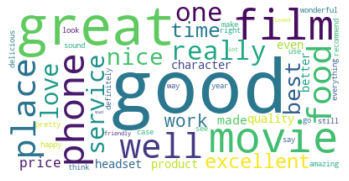

In [45]:
from wordcloud import WordCloud, ImageColorGenerator

# Create and generate a word cloud image for both bad reviews
pos_review_corpus = " ".join(review for review in reviews[reviews['score'] == 1]['cleaned_review'])

wordcloud = WordCloud(max_words=50, background_color="white").generate(pos_review_corpus)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

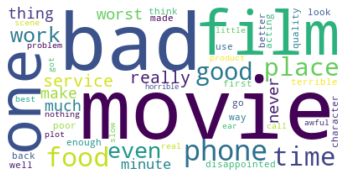

In [46]:
# Create and generate a word cloud image for both bad reviews
bad_review_corpus = " ".join(review for review in reviews[reviews['score'] == 0]['cleaned_review'])

wordcloud = WordCloud(max_words=50, background_color="white").generate(bad_review_corpus)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Even though the word cloud above is nice, we can see that there are a lot of overlaps in the terms that show up between good and bad reviews. A more useful diagram might be one of the top adjectives in the reviews. So below we find the top adjectives in bad and positive reviews.

In [47]:
from nltk.tokenize import PunktSentenceTokenizer
from collections import Counter
from PIL import Image

def concat_sentences(df):
    return ' '.join(df)

custom_sent_tokenizer = PunktSentenceTokenizer()

def tag_abstract(abstract):
    tokenized = custom_sent_tokenizer.tokenize(abstract)
    
    tags = []
    
    try:
        for token in tokenized:
            words = nltk.word_tokenize(token)
            tagged = nltk.pos_tag(words)

            tags = tags + tagged
    except Exception as e:
        print(str(e))
        
    return tags
        
def tag_corpus(df):
    tags = []
    
    for abstract in df:
        tags.append(tag_abstract(abstract))
        
    return tags

In [48]:
reviews['tags'] = reviews['review'].apply(lambda x: tag_abstract(x))
print(reviews['tags'])

0      [(A, DT), (very, RB), (,, ,), (very, RB), (,, ...
1      [(Not, RB), (sure, JJ), (who, WP), (was, VBD),...
2      [(Attempting, VBG), (artiness, NN), (with, IN)...
3      [(Very, RB), (little, JJ), (music, NN), (or, C...
4      [(The, DT), (best, JJS), (scene, NN), (in, IN)...
                             ...                        
995    [(The, DT), (screen, NN), (does, VBZ), (get, V...
996    [(What, WP), (a, DT), (piece, NN), (of, IN), (...
997    [(Item, NN), (Does, VBZ), (Not, RB), (Match, N...
998    [(The, DT), (only, JJ), (thing, NN), (that, IN...
999    [(You, PRP), (can, MD), (not, RB), (answer, VB...
Name: tags, Length: 2714, dtype: object


In [49]:
def get_top_n_pos(df, n = 10):
    counter = Counter()
    
    for item in df:
        for tag in item:
            if tag[1] in adjectives:
                counter[tag[0]] += 1

    return counter.most_common(n)

# JJ	adjective	'big'
# JJR	adjective, comparative	'bigger'
# JJS	adjective, superlative	'biggest'
adjectives = ['JJ', 'JJR', 'JJS']

bad_reviews_adj = get_top_n_pos(reviews[reviews['score'] == 0]['tags'], 30)
good_reviews_adj = get_top_n_pos(reviews[reviews['score'] == 1]['tags'], 30)

In [50]:
bad_reviews_df = pd.DataFrame(bad_reviews_adj, columns = ['Text', 'count'])

fig = px.bar(bad_reviews_df, y='count', x='Text')
fig.update_layout(title_text='top adjectives found in bad reviews')
fig.show()

In [51]:
good_reviews_adj = pd.DataFrame(good_reviews_adj, columns = ['Text', 'count'])

fig = px.bar(good_reviews_adj, y='count', x='Text')
fig.update_layout(title_text='top adjectives found in positive reviews')
fig.show()

### Part 3: Generating TF-IDF & Naive Bayes Classifier

Generate TF-IDF features from the tokens of each text. This will generate a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency).

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
tfidf_vectorizer = TfidfVectorizer()
vectorizer_count = tfidf_vectorizer.fit_transform(reviews['cleaned_review'])

In [54]:
print(tfidf_vectorizer.get_feature_names()[0:100])
print(vectorizer_count.shape)

['aailiyah', 'abandoned', 'abhor', 'ability', 'able', 'abound', 'abovepretty', 'abroad', 'absolute', 'absolutel', 'absolutely', 'absolutley', 'abstruse', 'abysmal', 'ac', 'academy', 'accents', 'accept', 'acceptable', 'access', 'accessable', 'accessible', 'accessing', 'accessory', 'accessoryone', 'accident', 'accidentally', 'acclaimed', 'accolades', 'accommodations', 'accomodate', 'accompanied', 'according', 'accordingly', 'accountant', 'accurate', 'accurately', 'accused', 'ache', 'achievement', 'achille', 'ackerman', 'acknowledged', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'activate', 'activated', 'activesync', 'actor', 'actors', 'actorsan', 'actress', 'actresses', 'actual', 'actually', 'ad', 'adams', 'adaptation', 'adapter', 'adapters', 'add', 'added', 'addition', 'additional', 'address', 'adhesive', 'admins', 'admiration', 'admitted', 'adorable', 'adorablethe', 'adrift', 'adventure', 'advertised', 'advise', 'aerial', 'aesthetically', 'affected', 'affleck', 'affordable

#### Multinomial naive Bayes with TF-IDF

In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [56]:
reviews_x = reviews['cleaned_review']
reviews_y = reviews['score']

# Why split before doing the TF-IDF?
# We do this to simulate the "real word' in which the future data has words we haven't seen before.
# If we vectorize and then split, the document-term matrix would know all the words in the text. This isn't very
# real world like. Source: https://bit.ly/2PhUIkE
x_train, x_test, y_train, y_test = train_test_split(reviews_x, reviews_y, random_state=1)

In [57]:
mnb = MultinomialNB()

In [58]:
cv1 = TfidfVectorizer(min_df=1,stop_words='english')

# learn training data vocab and create a document-term matrix
x_traincv=cv1.fit_transform(x_train)

# Transform the testing data into a document-term matrix
x_testcv=cv1.transform(x_test)

# Train the model and time it
%time mnb.fit(x_traincv, y_train)

CPU times: user 1.09 ms, sys: 53 µs, total: 1.14 ms
Wall time: 1.15 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [59]:
# Predict for x_testcv
prediction = mnb.predict(x_testcv)

In [60]:
# Calculate accuraccy
tf_idf_acc = metrics.accuracy_score(y_test, prediction)
tf_idf_acc

0.7555228276877761

This shows that our model accuracy is `0.7555228276877761`

#### Multinomial naive Bayes with Count Frequency


In [61]:
cv2 = CountVectorizer(min_df=1, stop_words='english')
mnb2 = MultinomialNB()

In [62]:
x_train_count_vect = cv2.fit_transform(x_train)
x_test_count_vect = cv2.transform(x_test)

# Train the model with the count vect
%time mnb2.fit(x_train_count_vect, y_train)

CPU times: user 1.16 ms, sys: 77 µs, total: 1.24 ms
Wall time: 1.24 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [63]:
# let the model make prediction
cf_prediction = mnb.predict(x_test_count_vect)

In [64]:
count_vect_acc = metrics.accuracy_score(y_test, cf_prediction)
count_vect_acc

0.7584683357879234

This shows that our model accuracy is `0.7584683357879234`

In [65]:
abs(tf_idf_acc - count_vect_acc)

0.002945508100147265

#### Comparison between classifier with word frequency and TF-IDF

The major difference between the two classifiers above is that their accuracy is slightly different. The classifier that uses the TF-IDF features is `0.002945508100147265` more accurate than the classifier that uses just the term frequency.

### Part 4: Comments about optimizations in the first dataset

Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be habdled differently as well. What are those inefficent parts you noticed? How can you improve the Data preprocessing for these specific datasets? This part is worth 10% of your grade.

#### Suggestions

One approach that could have been taken in the lab was to remove meaningless terms from the document term matrix (DTM).

For example, there were a number of terms that were only underscores and numbers. So your DTM would have values such as this: `___`, `___`, `22424`, `adas413`. These don't really contribute much to the DTM so removing them helps to reduce the dimensions.

Stopwords could have also been removed from the email text as well. This would remove words such as `I`, `we`, `would`.

